In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simim.siminterface as sim
from simim.galprops import Prop
from astropy import units as u, constants as con
from astropy.cosmology import Planck18 as cosmo

tng100 = sim.SimHandler('TNG100-1')

rng = np.random.default_rng(1511)

pixel_size = tng100.box_edge_no_h / 450
z_for_modeling = .64
tng100_snap = tng100.get_snap_from_z(z_for_modeling)

bins = np.logspace(-3,3,21)
bin_centers = (bins[1:] + bins[:-1]) / 2
k = 2*np.pi * bin_centers

In [2]:
from simim import constants as sc
from simim.galprops import prop_behroozi_sfr, prop_delooze_cii

tng100_snap.make_property(prop_behroozi_sfr, other_kws={'rng': rng}, overwrite=True, rename='sfr_behroozi')
tng100_snap.make_property(prop_delooze_cii, other_kws={'rng': rng}, overwrite=True, rename='LCII', kw_remap={'sfr': 'sfr_behroozi'})

d = tng100_snap.cosmo.comoving_distance(z_for_modeling).value
yfactor = sc.c / sc.nu_cii * (1+z_for_modeling)**2 / (1000*tng100_snap.cosmo.H(z_for_modeling).value)
dl = (1+z_for_modeling)*d

convnucii = sc.Lsun_to_W / (4*np.pi*dl**2) * d**2 * yfactor / pixel_size**3 \
    * 1 / 3.0857e22**2 *1e26 # Convert to Jy/sr from Lsun/Mpc^3

grid_CII = tng100_snap.grid('LCII', res=pixel_size, norm=convnucii)

ps_CII = grid_CII.power_spectrum(in_place=False,normalize=True)

# Spherical average
_,ps1d = ps_CII.spherical_average(ax=[0,1,2],shells=bins)
ps1d_CII = ps1d[:,0] / np.prod(grid_CII.side_length)  # Normalize by volume

/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:312: UserWarning: Property sfr_behroozi already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:312: UserWarning: Property LCII already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/map/gridder.py:1753: RuntimeWarning: invalid value encountered in divide
  binned_averages /= binned_weights


In [5]:
from simim.galprops import prop_halpha, prop_galaxy_survey

tng100_snap.make_property(prop_halpha, other_kws={'rng': rng}, overwrite=True, kw_remap={'sfr': 'sfr_behroozi'})
tng100_snap.make_property(prop_galaxy_survey, other_kws={'fluxcut': 6e-17, 'NIIcorr':0.4}, overwrite=True)

/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:312: UserWarning: Property LHa already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:312: UserWarning: Property ngal already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))


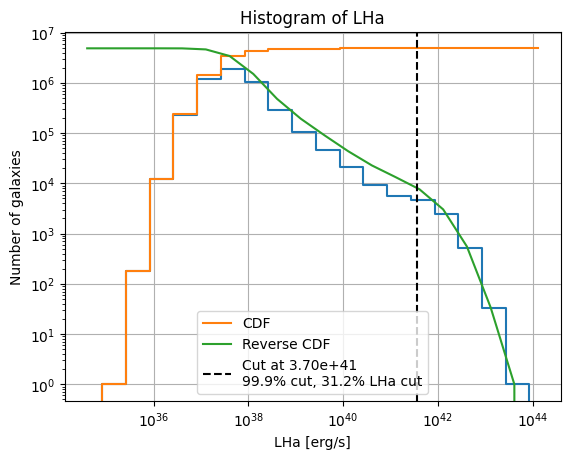

In [6]:
# histogram of SFR in logarithmic bins
dL = cosmo.luminosity_distance(z_for_modeling).to(u.cm).value
LHa = tng100_snap.return_property('LHa') # in Lsun
LHa = LHa * u.Lsun.to(u.erg/u.s) # convert to erg/s
LHa_bins = np.logspace(np.min(np.log10(LHa[LHa>0]))-1, np.max(np.log10(LHa))+1, 21)
LHa_hist, _ = np.histogram(LHa, bins=LHa_bins)
LHa_bin_centers = (LHa_bins[1:] + LHa_bins[:-1]) / 2

LHa_cut_val = 2e-16 # in erg/s/cm^2
LHa_cut_val = LHa_cut_val * 4 * np.pi * dL**2 # in erg/s
numcut = np.sum(LHa < LHa_cut_val) / np.size(LHa)
LHa_cut = np.sum(LHa[LHa < LHa_cut_val]) / np.sum(LHa)

plt.figure()
plt.plot(LHa_bin_centers, LHa_hist, drawstyle='steps-mid')
plt.loglog(LHa_bin_centers, np.cumsum(LHa_hist), drawstyle='steps-mid', label='CDF')
plt.loglog(LHa_bin_centers, np.cumsum(LHa_hist[::-1])[::-1], label='Reverse CDF')
plt.axvline(LHa_cut_val, color='k', linestyle='--', \
    label=f'Cut at {LHa_cut_val:.2e} \n{numcut*100:.1f}% cut, {LHa_cut*100:.1f}% LHa cut')
plt.legend()
plt.xlabel('LHa [erg/s]')
plt.ylabel('Number of galaxies')
plt.title('Histogram of LHa')
plt.grid()
plt.show()
plt.close()

In [ ]:
mean_ngal = tng100_snap.return_property('ngal').sum() / tng100_snap.box_edge_no_h**3
print(f'Mean ngal: {mean_ngal:.4e} Mpc^-3')
print(f'Mean ngal: {mean_ngal*cosmo.h**3:.4e} h^3 Mpc^-3')

Mean ngal: 8.6965e-03 Mpc^-3
Mean ngal: 2.6936e-03 h^3 Mpc^-3


In [8]:
from simim.map import Gridder

grid_gal = tng100_snap.grid('ngal', res=pixel_size)
grid_gal.grid /= np.mean(grid_gal.grid)
grid_gal.grid -= 1.0
ps_gal = grid_gal.power_spectrum(in_place=False,normalize=True)
# Spherical average
_,ps1d = ps_gal.spherical_average(ax=[0,1,2],shells=bins)
ps1d_gal = ps1d[:,0] / np.prod(grid_gal.side_length)  # Normalize by volume

/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/map/gridder.py:1753: RuntimeWarning: invalid value encountered in divide
  binned_averages /= binned_weights


In [9]:
crossps = grid_CII.power_spectrum(cross_grid=grid_gal, in_place=False, normalize=True)

_,ps1d = crossps.spherical_average(ax=[0,1,2],shells=bins)
ps1d_cross = ps1d[:,0] / np.prod(grid_CII.side_length)  # Normalize by volume

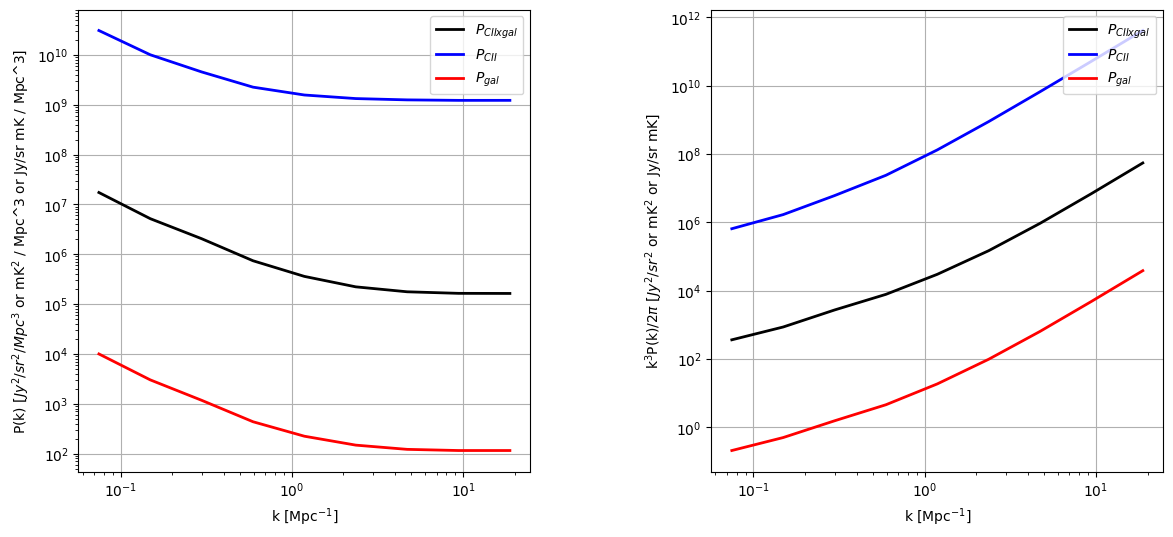

In [10]:
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$Jy^2/sr^2/Mpc^3$ or mK$^2$ / Mpc^3 or Jy/sr mK / Mpc^3]',xscale='log',yscale='log')
ax[0].grid()
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$Jy^2/sr^2$ or mK$^2$ or Jy/sr mK]',xscale='log',yscale='log')
ax[1].grid()

ax[0].plot(k,ps1d_cross,lw=2,color='k', label='$P_{CII x gal}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_cross,lw=2,color='k', label='$P_{CII x gal}$')
ax[0].plot(k,ps1d_CII,lw=2,color='b', label='$P_{CII}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_CII,lw=2,color='b', label='$P_{CII}$')
ax[0].plot(k,ps1d_gal,lw=2,color='r', label='$P_{gal}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_gal,lw=2,color='r', label='$P_{gal}$')


ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

# plt.savefig('../figs/cross_ps.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [11]:
import camb
from camb import model, initialpower
from astropy import units as u, constants as con

mink = k[~np.isnan(ps1d_cross)][0]
maxk = k[~np.isnan(ps1d_cross)][-1]
npoints = len(k[~np.isnan(ps1d_cross)])

pars = camb.CAMBparams()
pars.set_cosmology(H0=cosmo.H(0).value, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, As=2e-9, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.set_matter_power(redshifts=[z_for_modeling], kmax=maxk*3, nonlinear=False) 
results = camb.get_results(pars)
khs, z, ps = results.get_matter_power_spectrum(minkh=mink/cosmo.h, maxkh=maxk/cosmo.h, npoints=npoints)
ks = khs * cosmo.h

pars.set_matter_power(redshifts=[z_for_modeling], kmax=maxk*3, nonlinear=True)
results = camb.get_results(pars)
khsnl, znl, psnl = results.get_matter_power_spectrum(minkh=mink/cosmo.h, maxkh=maxk/cosmo.h, npoints=npoints)
ksnl = khsnl * cosmo.h

bias = (np.sqrt(ps1d_gal[~np.isnan(ps1d_cross)] / ps))[0][0]

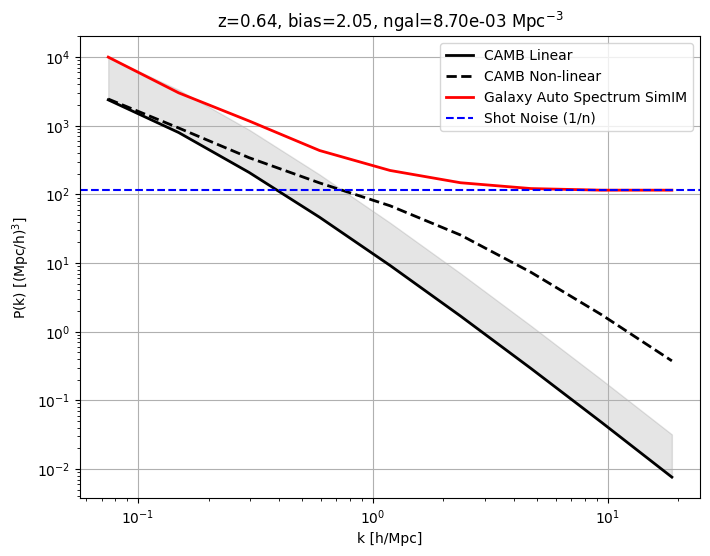

In [12]:
plt.figure(figsize=(8,6))
plt.loglog(ks, ps[0], lw=2, color='k', label='CAMB Linear')
plt.loglog(ksnl, psnl[0], lw=2, color='k', ls='--', label='CAMB Non-linear')
plt.loglog(k, ps1d_gal, lw=2, color='r', label='Galaxy Auto Spectrum SimIM')
# plt.loglog(k, ps1d_gal - 1/mean_n, lw=1, color='r', label='Auto SimIM - Shot Noise', ls='--')
plt.fill_between(ks, ps[0], bias**2*ps[0], color='k', alpha=0.1)
# plt.loglog(k, (ps1d_CII - ps1d_CII[~np.isnan(ps1d_CII)][-1]), lw=2, color='b')
plt.axhline(1/mean_ngal, color='b', ls='--', label='Shot Noise (1/n)')
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k) [(Mpc/h)$^3$]')
plt.title(f'z={z_for_modeling}, bias={bias:.2f}, ngal={mean_ngal:.2e} Mpc$^{{-3}}$')
plt.legend()
plt.grid()
plt.show()
plt.close()

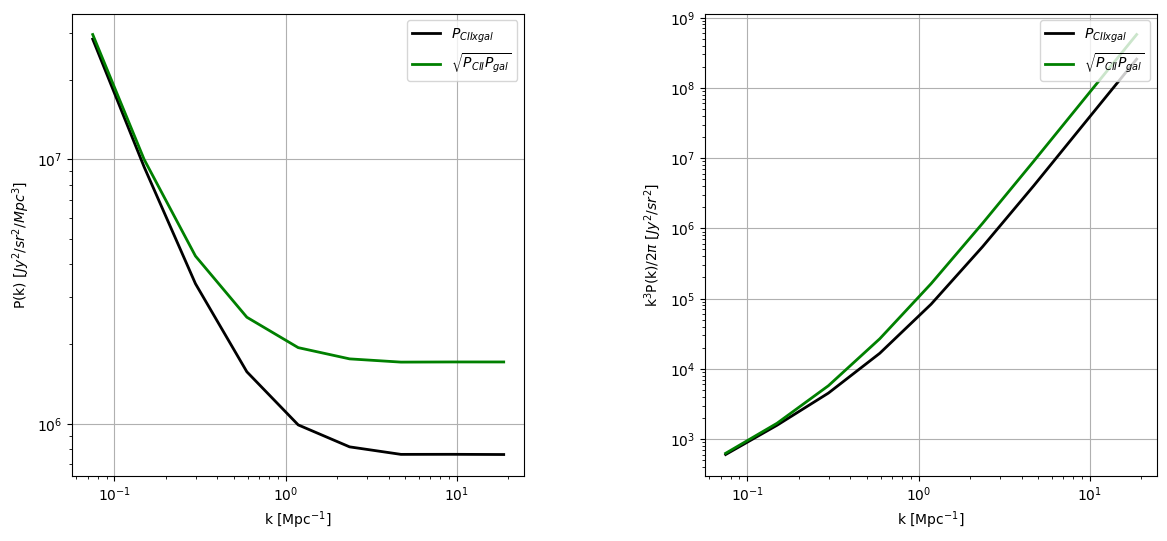

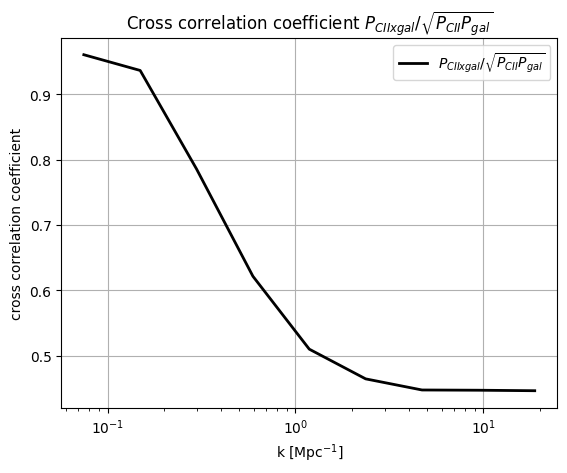

In [29]:
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$Jy^2/sr^2/Mpc^3$]',xscale='log',yscale='log')
ax[0].grid()
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$Jy^2/sr^2$]',xscale='log',yscale='log')
ax[1].grid()

ax[0].plot(k,ps1d_cross,lw=2,color='k', label='$P_{CII x gal}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_cross,lw=2,color='k', label='$P_{CII x gal}$')
prod_ps = np.sqrt(ps1d_CII * ps1d_gal)
ax[0].plot(k,prod_ps,lw=2,color='g', label='$\sqrt{P_{CII}P_{gal}}$')
ax[1].plot(k,k**3/2/np.pi**2*prod_ps,lw=2,color='g', label='$\sqrt{P_{CII}P_{gal}}$')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

plt.show()
plt.close()

plt.figure()
plt.plot(k,ps1d_cross/prod_ps,lw=2,color='k', label='$P_{CII x gal} / \sqrt{P_{CII}P_{gal}}$')
plt.xscale('log')
plt.grid()
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('cross correlation coefficient')
plt.title('Cross correlation coefficient $P_{CII x gal} / \sqrt{P_{CII}P_{gal}}$')
plt.legend()
# plt.savefig('../figs/cross_coeff.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [31]:
d = tng100_snap.cosmo.comoving_distance(z_for_modeling).value
yfactor = sc.c / sc.nu_halpha * (1+z_for_modeling)**2 / (1000*tng100_snap.cosmo.H(z_for_modeling).value)
dl = (1+z_for_modeling)*d

conv_nu_halhia = sc.Lsun_to_W / (4*np.pi*dl**2) * d**2 * yfactor / pixel_size**3 \
    * 1 / 3.0857e22**2 *1e26 # Convert to Jy/sr from Lsun/Mpc^3

grid_halpha = tng100_snap.grid('LHa', res=pixel_size, norm=conv_nu_halhia)
ps_halpha = grid_halpha.power_spectrum(in_place=False,normalize=True)
# Spherical average
_,ps1d = ps_halpha.spherical_average(ax=[0,1,2],shells=bins)
ps1d_halpha = ps1d[:,0] / np.prod(grid_halpha.side_length)  # Normalize by volume

/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/map/gridder.py:1753: RuntimeWarning: invalid value encountered in divide
  binned_averages /= binned_weights


In [32]:
crosspsha = grid_CII.power_spectrum(cross_grid=grid_halpha, in_place=False, normalize=True)

_,ps1d = crosspsha.spherical_average(ax=[0,1,2],shells=bins)
ps1d_crossha = ps1d[:,0] / np.prod(grid_CII.side_length)  # Normalize by volume

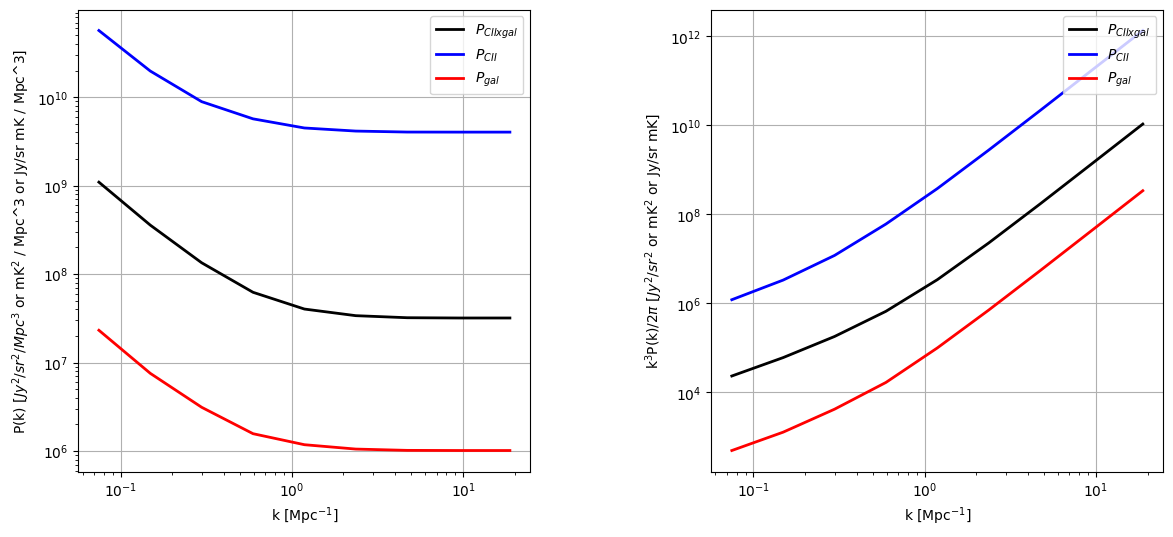

In [34]:
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$Jy^2/sr^2/Mpc^3$ or mK$^2$ / Mpc^3 or Jy/sr mK / Mpc^3]',xscale='log',yscale='log')
ax[0].grid()
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$Jy^2/sr^2$ or mK$^2$ or Jy/sr mK]',xscale='log',yscale='log')
ax[1].grid()

ax[0].plot(k,ps1d_crossha,lw=2,color='k', label='$P_{CII x gal}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_crossha,lw=2,color='k', label='$P_{CII x gal}$')
ax[0].plot(k,ps1d_CII,lw=2,color='b', label='$P_{CII}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_CII,lw=2,color='b', label='$P_{CII}$')
ax[0].plot(k,ps1d_halpha,lw=2,color='r', label='$P_{gal}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_halpha,lw=2,color='r', label='$P_{gal}$')


ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

# plt.savefig('../figs/cross_ps.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

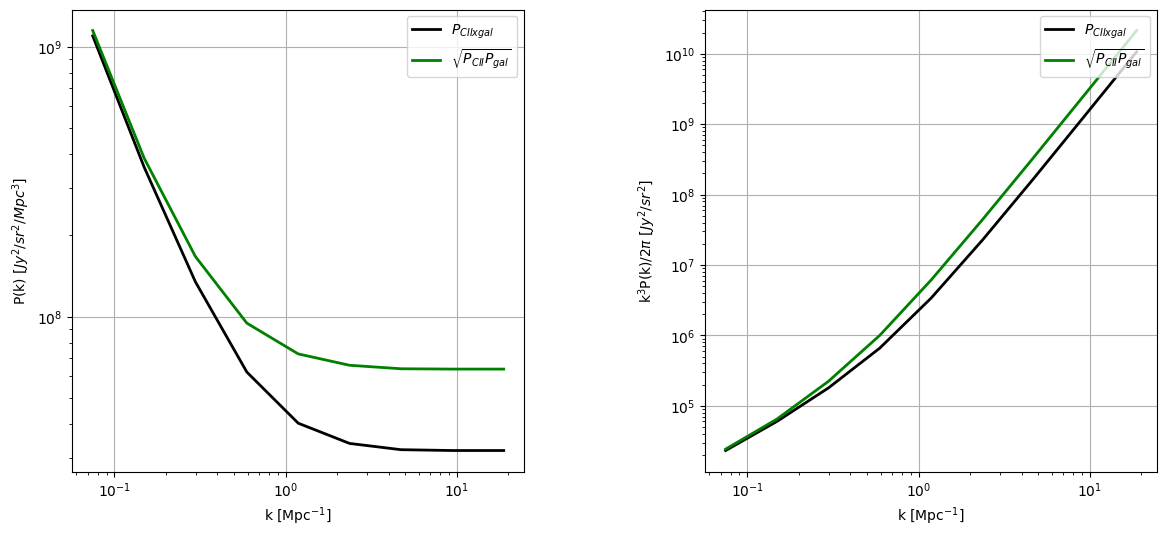

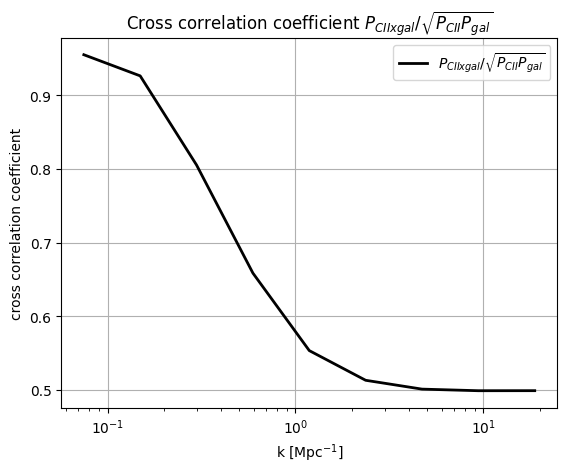

In [36]:
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$Jy^2/sr^2/Mpc^3$]',xscale='log',yscale='log')
ax[0].grid()
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$Jy^2/sr^2$]',xscale='log',yscale='log')
ax[1].grid()

ax[0].plot(k,ps1d_crossha,lw=2,color='k', label='$P_{CII x gal}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_crossha,lw=2,color='k', label='$P_{CII x gal}$')
prod_ps = np.sqrt(ps1d_CII * ps1d_halpha)
ax[0].plot(k,prod_ps,lw=2,color='g', label='$\sqrt{P_{CII}P_{gal}}$')
ax[1].plot(k,k**3/2/np.pi**2*prod_ps,lw=2,color='g', label='$\sqrt{P_{CII}P_{gal}}$')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

plt.show()
plt.close()

plt.figure()
plt.plot(k,ps1d_crossha/prod_ps,lw=2,color='k', label='$P_{CII x gal} / \sqrt{P_{CII}P_{gal}}$')
plt.xscale('log')
plt.grid()
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('cross correlation coefficient')
plt.title('Cross correlation coefficient $P_{CII x gal} / \sqrt{P_{CII}P_{gal}}$')
plt.legend()
# plt.savefig('../figs/cross_coeff.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
def gal(flux_Halpha):
    ones = np.ones_like(flux_Halpha, dtype=float)
    ones[flux_Halpha < LHa_cut_val] = 0.0
    return ones

prop_gal = Prop(prop_name='ngal',
                 prop_function=gal,
                 kwargs=['flux_Halpha'],
                 units="")

tng100_snap.make_property(prop_gal, overwrite=True)

ngals = tng100_snap.return_property('ngal')
print(np.sum(ngals) / np.size(ngals) * 100, '% of galaxies remain after cut')

mean_n = np.dtng100_snap.box_edge_no_h**3
print('Mean Density of galaxies after cut:', f"{mean_n:.3e}", 'Mpc^-3')
print('Mean Density of galaxies after cut:', f"{mean_n*cosmo.h**3:.3e}", 'h/Mpc^-3')